# Time Series with the Prophet Module

This notebook uses hourly energy demand data from ERCOT in Texas to predict future demand. This version uses data from multiple years.

In [1]:
! pip install -q -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # For plot style
%matplotlib inline

from prophet import Prophet

In [3]:
df = pd.read_csv("data/Native_Load.csv")

In [4]:
df.head()

,date,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,2018-01-01 00:00:00,11425.979115,1852.663959,2823.409245,1135.360907,18584.343617,3831.649454,9151.190703,1762.472684,50567.069682
1,2018-01-01 01:00:00,11408.418023,1850.169452,2809.745403,1136.630855,18524.141392,3988.271046,9144.993712,1754.718094,50617.087977
2,2018-01-01 02:00:00,11405.198365,1858.269586,2797.802576,1135.930264,18532.056616,4076.086451,9141.036615,1747.919615,50694.300087
3,2018-01-01 03:00:00,11450.560138,1879.623596,2807.793880,1146.069491,18647.444612,4154.939804,9157.956866,1755.203307,50999.591693
4,2018-01-01 04:00:00,11631.337459,1876.481320,2822.989206,1154.186967,19002.102222,4247.451523,9214.333628,1774.849690,51723.732017


In [5]:
df["date"].dtype

dtype('O')

In [6]:
df["date"] = pd.to_datetime(df["date"])

In [7]:
df.set_index("date", inplace=True)

<AxesSubplot:xlabel='date'>

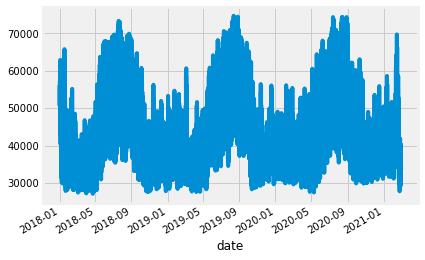

In [8]:
df["ERCOT"].plot()

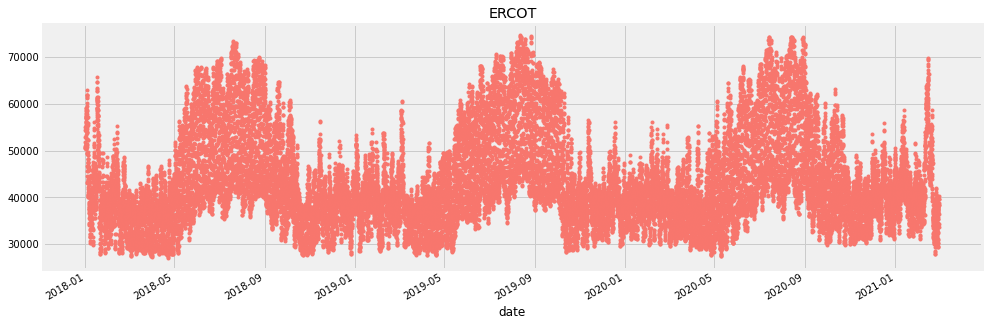

In [9]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

#df.set_index("date", inplace=True)
df["ERCOT"].plot(style='.', figsize=(15,5), color=color_pal[0], title='ERCOT')
plt.show()

In [10]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='ERCOT')

features_and_target = pd.concat([X, y], axis=1)

In [11]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,ERCOT
date,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,1.0,1.0,2018.0,1.0,1.0,1,50567.069682
2018-01-01 01:00:00,1.0,0.0,1.0,1.0,2018.0,1.0,1.0,1,50617.087977
2018-01-01 02:00:00,2.0,0.0,1.0,1.0,2018.0,1.0,1.0,1,50694.300087
2018-01-01 03:00:00,3.0,0.0,1.0,1.0,2018.0,1.0,1.0,1,50999.591693
2018-01-01 04:00:00,4.0,0.0,1.0,1.0,2018.0,1.0,1.0,1,51723.732017


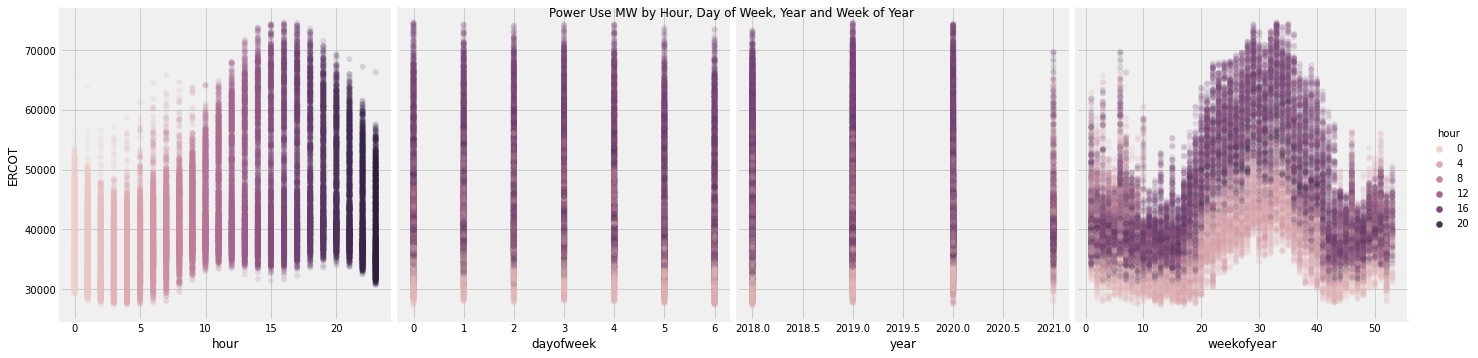

In [12]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='ERCOT',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [13]:
df.reset_index(inplace=True)
df1 = df[["date", "ERCOT"]]

In [14]:
df1.dropna(inplace=True)

df1.columns = ["ds", "y"]

m = Prophet()
m.fit(df1)

<ipython-input-14-9c799f114946>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(inplace=True)


In [15]:
future = m.make_future_dataframe(periods=12)
future.tail()

,ds
27724,2021-03-09 23:00:00
27725,2021-03-10 23:00:00
27726,2021-03-11 23:00:00
27727,2021-03-12 23:00:00
27728,2021-03-13 23:00:00


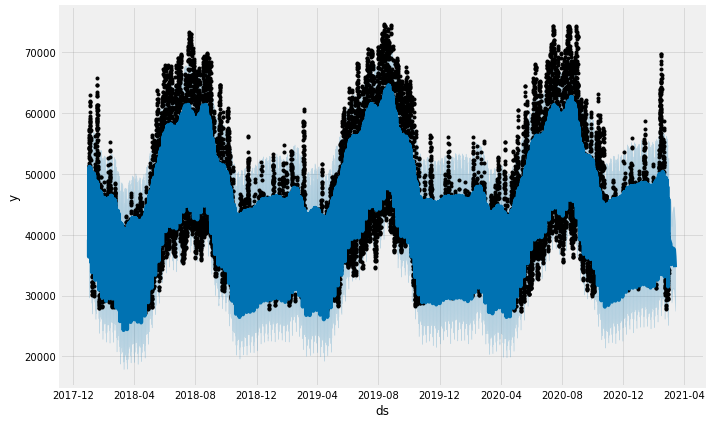

In [16]:
future = m.make_future_dataframe(periods=12, freq='D')
fcst = m.predict(future)
fig = m.plot(fcst)

In [17]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
27724,2021-03-09 23:00:00,37731.896524,31037.875984,44172.590061
27725,2021-03-10 23:00:00,37670.142309,31052.427642,44140.470816
27726,2021-03-11 23:00:00,37575.229476,30698.068888,44459.138674
27727,2021-03-12 23:00:00,36424.549966,30054.617551,43264.523363
27728,2021-03-13 23:00:00,34665.024176,27782.371938,41330.739548


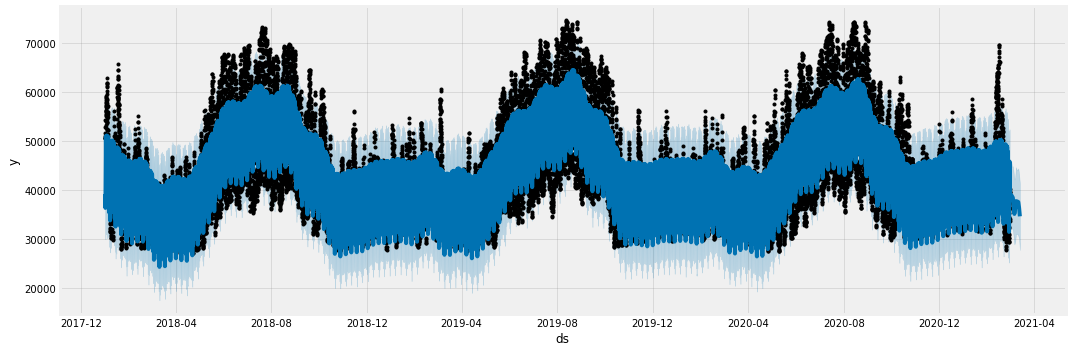

In [18]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m.plot(forecast,
                 ax=ax)
plt.show()

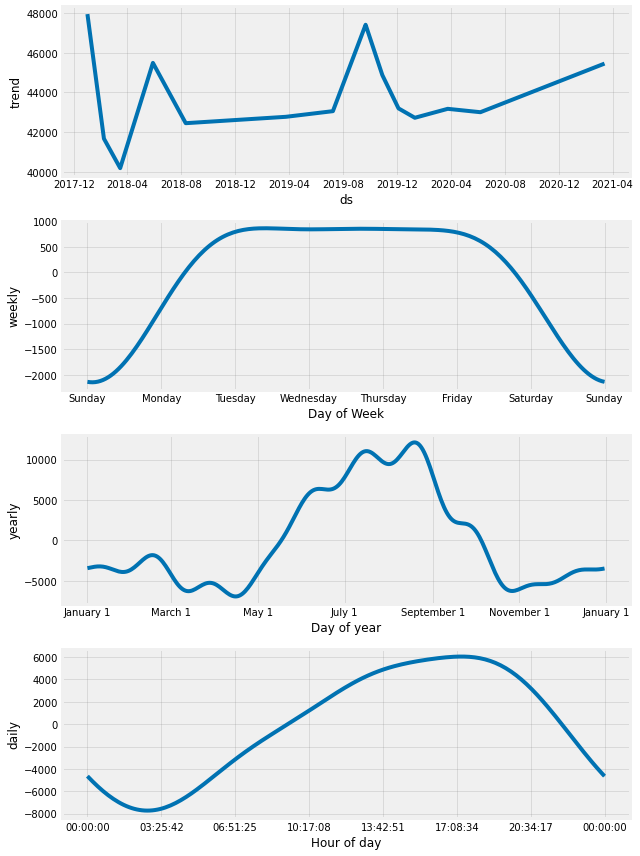

In [19]:
fig = m.plot_components(forecast)

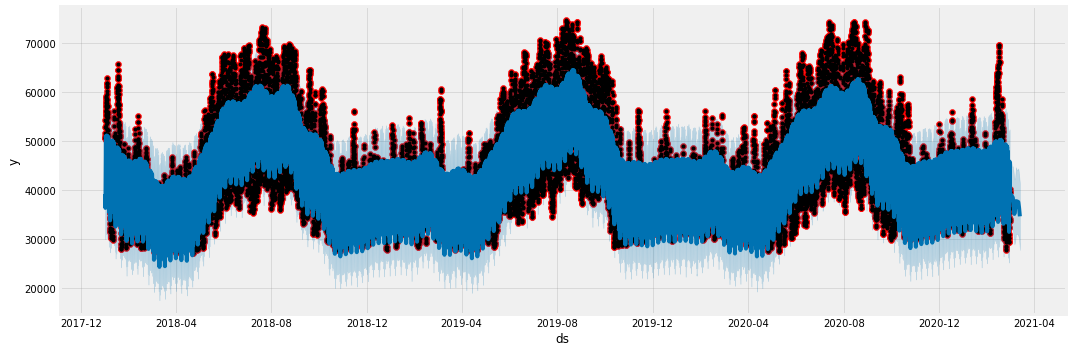

In [20]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df1["ds"], df1["y"], color='r')
fig = m.plot(forecast, ax=ax)